# MNIST SRGAN
Implementation of SRGAN for generating MNIST digits. This version does not include perceptual loss. To be used as a baseline for the more advanced GAN. 

The GAN is trained to upsample 7x7 MNIST images to 28x28

## Notebook setup

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as f
# from torchsummary import summary
import torch.optim as optim

from torchvision import models, transforms
import torchvision

import numpy as np
import os
import random

from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from PIL import Image

from keras.datasets import mnist

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download data and make generator

In [6]:
class MNISTDataset(torch.utils.data.Dataset):

  def __init__(self,
               hr_dims=(48,48),
               scale_factor=4,
               train=True):

        (train_x, _), (val_x, _) = mnist.load_data()
        if train:
            self.images = train_x
        else:
            self.images = val_x

        hr_height, hr_width = hr_dims
        scale_factor = scale_factor

        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height//scale_factor, hr_height//scale_factor), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )

  def __len__(self):
        return len(self.images)

  def _degrade_resolution(self, image):
        resized = cv2.resize(
            cv2.GaussianBlur(
                image,(3,3),cv2.BORDER_DEFAULT),(7,7))
        return resized

  def plot_sample(self):
        rand_ind = random.randint(0,self.__len__())
        fig, (ax1, ax2) = plt.subplots(1, 2)
        low_res, high_res = self.__getitem__(rand_ind)

        ax1.imshow(low_res.cpu().numpy()[0,...], cmap="gray")
        ax1.set_title("Low resolution")
        ax2.imshow(high_res.cpu().numpy()[0,...], cmap="gray")
        ax2.set_title("High resolution")

        for i in [ax1, ax2]:
            i.xaxis.set_visible(False)
            i.yaxis.set_visible(False) 

        plt.show()

  def __getitem__(self, index):
        # Select sample
        img = Image.fromarray(self.images[index,...])
        low_res = self.lr_transform(img)
        high_res = self.hr_transform(img)

        return low_res.to(device).float(), high_res.to(device).float()

Make the dataset and generator

In [7]:
image_dataset = MNISTDataset()

training_generator = torch.utils.data.DataLoader(image_dataset,
                                                 shuffle = True,
                                                 batch_size = 32
                                                )

11493376/11490434 [==============================] - 2s 0us/step


Plot some samples from the dataset to check the loader is doing the right thing

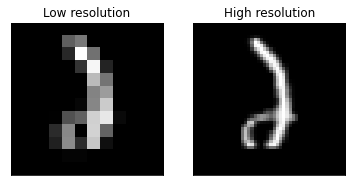

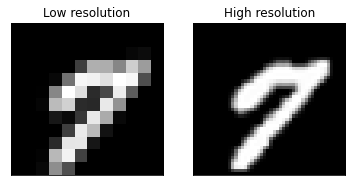

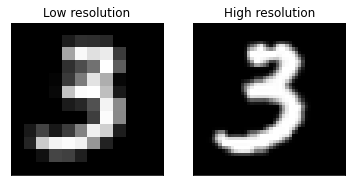

In [8]:
image_dataset.plot_sample()
image_dataset.plot_sample()
image_dataset.plot_sample()

## GAN model

### Generator

In [9]:
class ConvBlock(nn.Module):

    def __init__(self, n_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(n_channels,n_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(n_channels, 0.8),
            nn.PReLU(),
            nn.Conv2d(n_channels,n_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(n_channels, 0.8)
        )

    def forward(self, x):
        return x+self.conv(x)

In [10]:
class PixelShuffleBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.ps_block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

    def forward(self, x):
        return self.ps_block(x)

In [11]:
class Generator(nn.Module):

    def __init__(self, 
                 conv_channels=64, 
                 n_res_blocks=3,
                 n_ps_blocks=2):
        super().__init__()
        
        # Initial conv
        self.init_conv = nn.Sequential(
            nn.Conv2d(1,conv_channels,3,padding=1,bias=False),
            nn.PReLU()
        )

        # Residual blocks
        self.res = nn.Sequential(
            *[ConvBlock(conv_channels) for _ in range(n_res_blocks)]
        )

        # Conv after resnet
        self.res_end_conv = nn.Sequential(
            nn.Conv2d(conv_channels,conv_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(conv_channels)
        )

        # Pixel shuffle blocks
        self.ps_blocks = nn.Sequential(
            *[PixelShuffleBlock(conv_channels,256) for _ in range(n_ps_blocks)]
        )

        # Final conv to get channels right
        self.out_conv = nn.Conv2d(conv_channels,1,3,padding=1,bias=False)

    def forward(self, h):
        
        # Residual blocks
        h1 = self.init_conv(h)
        h = self.res(h1)
        h = self.res_end_conv(h)
        h = torch.add(h, h1)

        # Pixel shuffle blocks
        h = self.ps_blocks(h)

        # Output conv
        h = self.out_conv(h)

        return h

### Discriminator

In [12]:
class DiscConvBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 stride):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,
                      stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv_block(x)

In [13]:
class Discriminator(nn.Module):

    def __init__(self,
                 conv_channels=64,
                 conv_in_channels=[64,64,128],
                 conv_out_channels=[64,128,128],
                 stride=[2,1,2]):
        
        super().__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(1,conv_channels,3,padding=1,bias=False),
            nn.LeakyReLU()
        )

        self.conv_blocks = nn.Sequential(*[DiscConvBlock(*i) for 
                                          i in zip(conv_in_channels,
                                              conv_out_channels,
                                              stride)]
                                         )

        self.out_block = nn.Sequential(
            nn.Linear(18432, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1),
        )

    def forward(self, x):

        x = self.init_conv(x)
        x = self.conv_blocks(x)
        x = x.view(x.shape[0],-1)
        x = self.out_block(x)

        sig = nn.Sigmoid()
        x = sig(x/100)

        return x

## Trainer

In [ ]:
nn.fun

In [46]:
class Trainer():
    
    def __init__(self,
                 n_epochs,
                 disc,
                 gen,
                 gen_optim,
                 disc_optim,
                 train_data,
                 val_data):
        # Training 
        self.n_epochs = n_epochs

        # Model
        self.gen = gen
        self.disc = disc
        self.gen_optimizer = gen_optim
        self.disc_optimizer = disc_optim

        # Data
        self.train_data = train_data
        self.val_data = val_data

        # Losses
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()

    def get_disc_loss(self, pred_real, pred_fake):

        ground_truth_real = torch.ones_like(pred_real)
        ground_truth_fake = torch.zeros_like(pred_fake)

        disc_loss_real = self.mse(pred_real, ground_truth_real)
        disc_loss_fake = self.mse(pred_fake, ground_truth_fake)

        return disc_loss_fake+disc_loss_real

    def get_gen_loss(self, disc_fake, real_image, gen_image):

        ground_truth = torch.ones_like(disc_fake)
        adv_loss = self.mse(disc_fake, ground_truth)
        con_loss = self.l1(real_image, gen_image)

        return adv_loss*1e-3 + con_loss, adv_loss*1e-3, con_loss

    def plot_sample(self, low_res, high_res, gen_out, n_samples):

        for i in range(n_samples):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(high_res.cpu().numpy()[i,0,...], cmap="gray")
            ax1.set_title("Ground truth")
            ax2.imshow(low_res.cpu().numpy()[i,0,...], cmap="gray")
            ax2.set_title("Low-res")
            ax3.imshow(gen_out.cpu().detach().numpy()[i,0,...], cmap="gray")
            ax3.set_title("Generated")

            for i in [ax1, ax2]:
                i.xaxis.set_visible(False)
                i.yaxis.set_visible(False) 

            plt.show()

    def plot_losses(self, disc_loss_list, gen_loss_list, gen_adv_loss_list, gen_con_loss_list):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(np.array(disc_loss_list))
        ax1.set_title("Discriminator loss")
        ax2.plot(np.array(gen_loss_list), label='Total')
        ax2.plot(np.array(gen_adv_loss_list), label='adv')
        ax2.plot(np.array(gen_con_loss_list), label='con')
        ax2.set_title("Generator loss")
        ax2.legend()

        plt.show()
   
    def train(self):
        
        disc_loss_list = []
        gen_loss_list = []
        gen_adv_loss_list = []
        gen_con_loss_list = []
        
        for epoch in range(self.n_epochs):

            for low_res, high_res in tqdm(self.train_data):

                # Generator
                self.gen_optimizer.zero_grad()
                gen_out = self.gen(low_res)
                disc_fake = self.disc(gen_out)

                gen_loss, adv_loss, con_loss = self.get_gen_loss(disc_fake, high_res, gen_out)
                gen_loss.backward(retain_graph=True)

                # Discriminator
                self.disc_optimizer.zero_grad()
                disc_real = self.disc(high_res)

                disc_loss = self.get_disc_loss(disc_real, disc_fake)
                disc_loss.backward()
                self.gen_optimizer.step()
                self.disc_optimizer.step()
                
                disc_loss_list.append(disc_loss.item())
                gen_loss_list.append(gen_loss.item())
                gen_adv_loss_list.append(adv_loss.item())
                gen_con_loss_list.append(con_loss.item())
                #print("Disc loss = {}, Gen loss = {}".format(disc_loss.item(), gen_loss.item()))

            print("Discriminator loss is {}, generator loss is {}".format(
                np.mean(disc_loss_list), np.mean(gen_loss_list)
            ))

            # Plot losses
            self.plot_losses(disc_loss_list, gen_loss_list, gen_adv_loss_list, gen_con_loss_list)

            # Plot a sample
            self.plot_sample(low_res, high_res, gen_out, n_samples=3)



## Train model

In [47]:
# Training and validation datasets

train = MNISTDataset(train=True)
train_data = torch.utils.data.DataLoader(train,
                                         shuffle = True,
                                         batch_size = 128)

val = MNISTDataset(train=False)
val_data = torch.utils.data.DataLoader(val,
                                       shuffle = True,
                                       batch_size = 128)


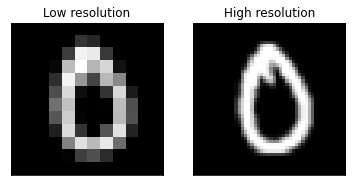

In [48]:
# Plot a sample
val.plot_sample()

In [49]:
# Define generator and discriminator
gen = Generator()
gen.to(device)
disc = Discriminator()
disc.to(device)
gen_optim = optim.Adam(gen.parameters(),lr=0.001)
disc_optim = optim.Adam(disc.parameters(),lr=0.001)

In [50]:
# Training class
trainer = Trainer(100,
                 disc,
                 gen,
                 gen_optim,
                 disc_optim,
                 train_data,
                 val_data)

In [51]:
X, y = next(iter(train_data))
gen_out = trainer.gen(X)

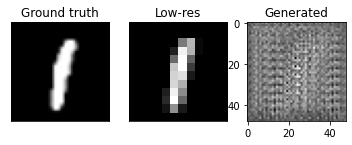

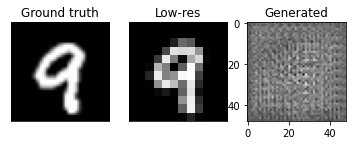

In [52]:
trainer.plot_sample(X, y, gen_out, 2)

100%|██████████| 469/469 [07:07<00:00,  1.10it/s]


Discriminator loss is 0.02888153530588832, generator loss is 0.11584946087428502


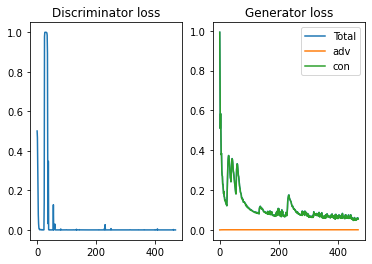

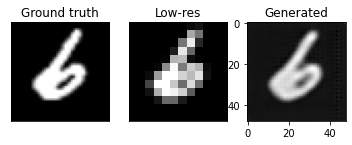

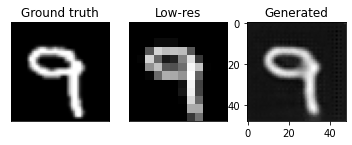

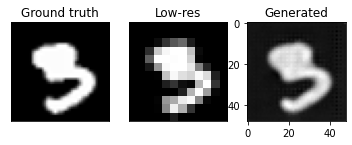

100%|██████████| 469/469 [07:09<00:00,  1.09it/s]


Discriminator loss is 0.014448075217717274, generator loss is 0.08461230701760951


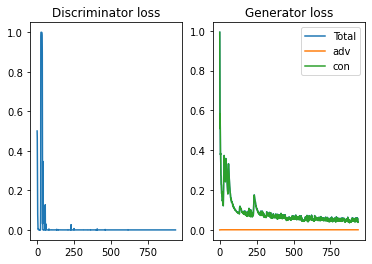

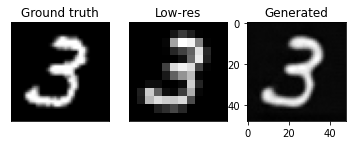

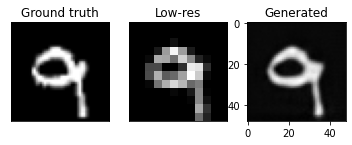

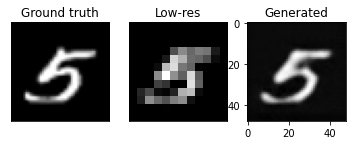

100%|██████████| 469/469 [07:10<00:00,  1.09it/s]


Discriminator loss is 0.009644121207326594, generator loss is 0.07188019293076447


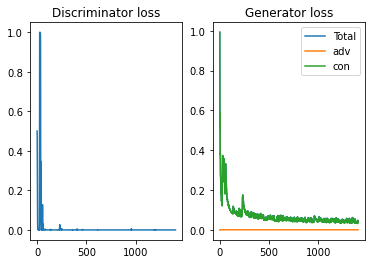

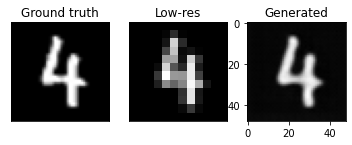

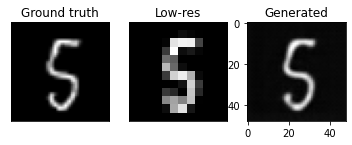

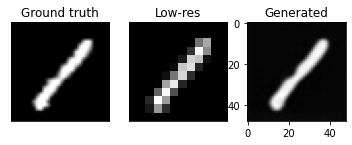

100%|██████████| 469/469 [07:05<00:00,  1.10it/s]


Discriminator loss is 0.0072346734085176265, generator loss is 0.06447965042419367


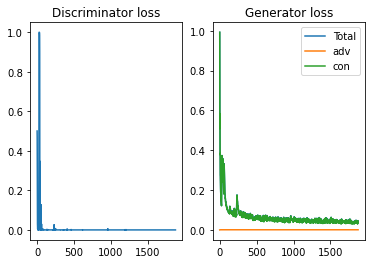

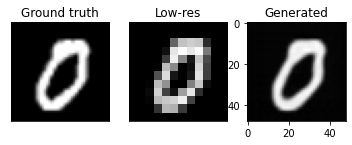

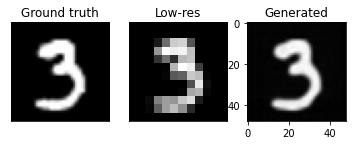

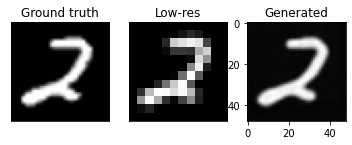

100%|██████████| 469/469 [07:06<00:00,  1.10it/s]


Discriminator loss is 0.0057972943968043434, generator loss is 0.059505616828227345


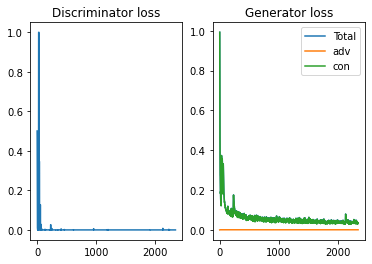

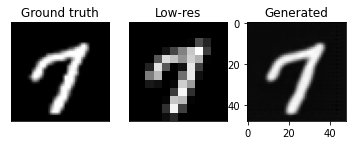

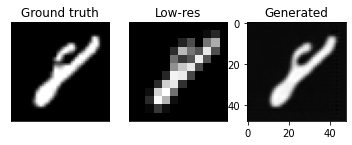

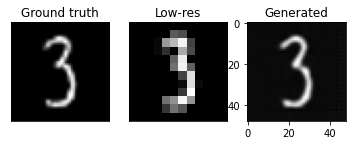

100%|██████████| 469/469 [07:05<00:00,  1.10it/s]


Discriminator loss is 0.004841014354623054, generator loss is 0.05608963095546616


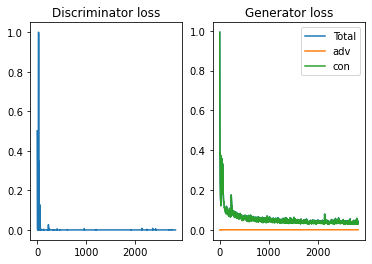

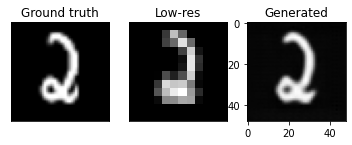

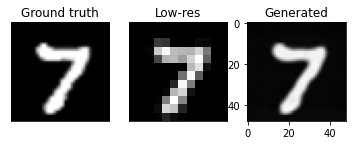

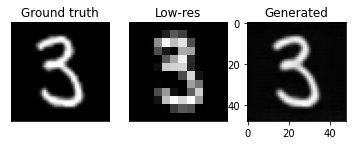

100%|██████████| 469/469 [06:34<00:00,  1.19it/s]


Discriminator loss is 0.004149990646813341, generator loss is 0.05318171764033762


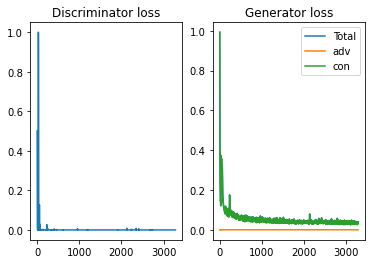

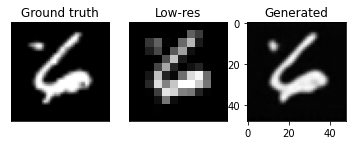

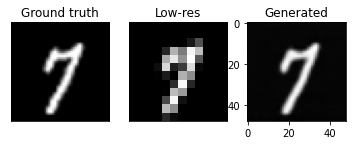

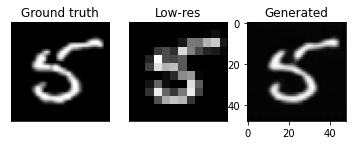

100%|██████████| 469/469 [03:05<00:00,  2.53it/s]


Discriminator loss is 0.003633991859608827, generator loss is 0.05070496427177239


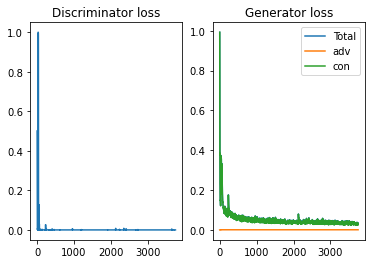

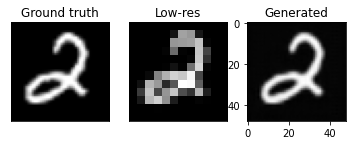

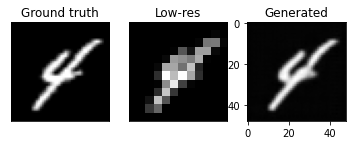

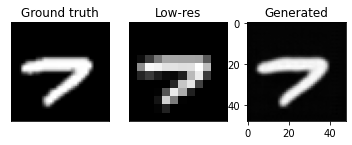

100%|██████████| 469/469 [03:04<00:00,  2.54it/s]


Discriminator loss is 0.07343937747616983, generator loss is 0.05221975111953951


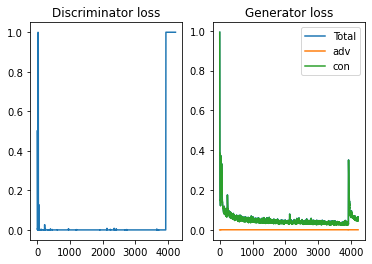

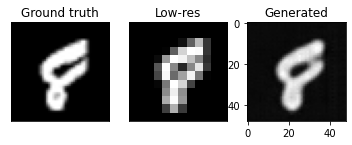

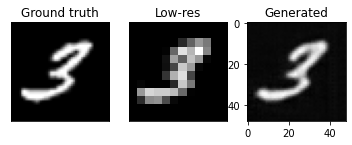

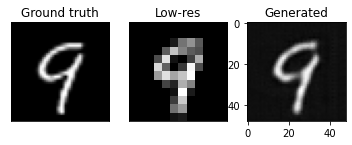

100%|██████████| 469/469 [06:44<00:00,  1.16it/s]


Discriminator loss is 0.16609543972855284, generator loss is 0.05149739438703637


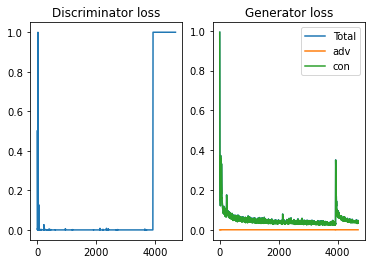

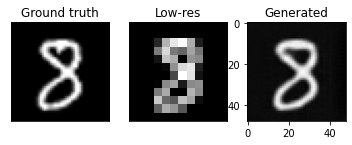

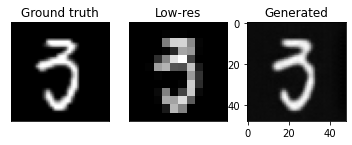

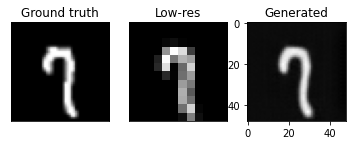

100%|██████████| 469/469 [07:02<00:00,  1.11it/s]


Discriminator loss is 0.24190494520777533, generator loss is 0.05035996087903511


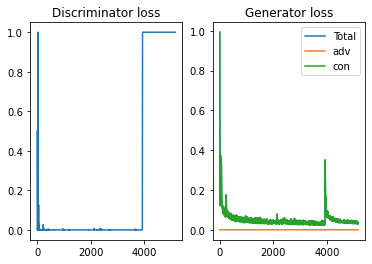

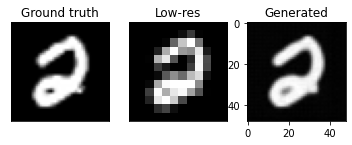

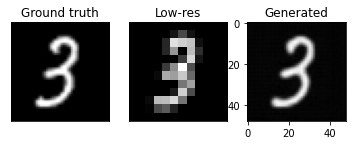

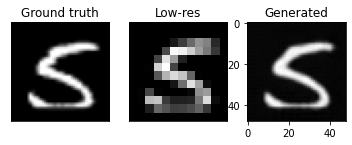

100%|██████████| 469/469 [07:03<00:00,  1.11it/s]


Discriminator loss is 0.3050795331071274, generator loss is 0.04917532910659708


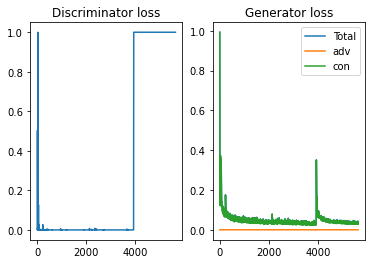

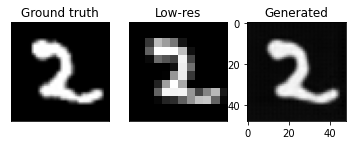

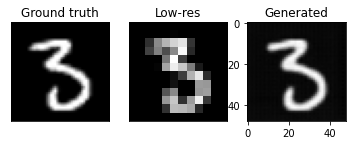

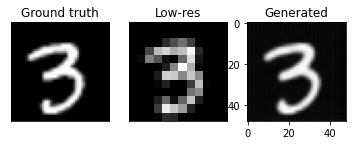

100%|██████████| 469/469 [07:02<00:00,  1.11it/s]


Discriminator loss is 0.35853495363734833, generator loss is 0.04799313767882953


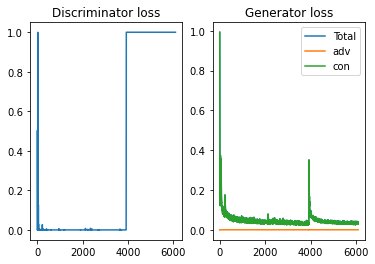

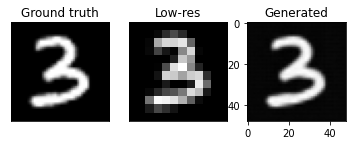

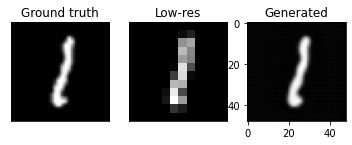

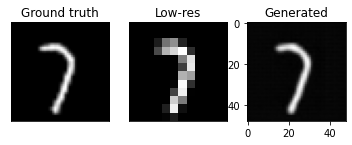

100%|██████████| 469/469 [07:01<00:00,  1.11it/s]


Discriminator loss is 0.404353885520395, generator loss is 0.046954148473116526


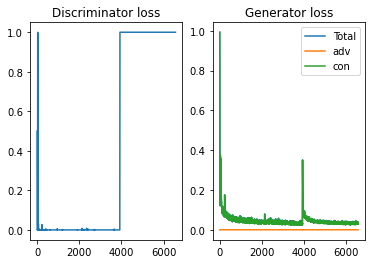

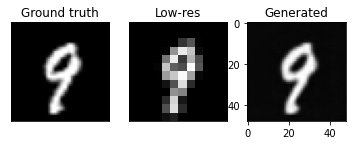

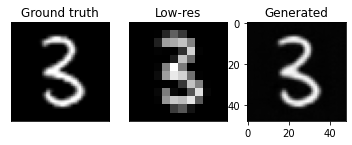

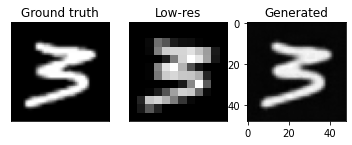

 17%|█▋        | 80/469 [01:12<05:58,  1.09it/s]

In [ ]:
trainer.train()

In [32]:
X, y = next(iter(val_data))
gen_out = trainer.gen(X)

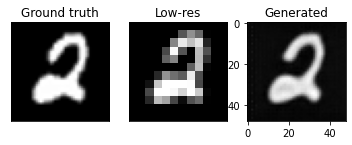

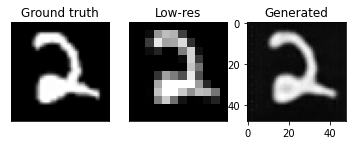

In [33]:
trainer.plot_sample(X, y, gen_out, 2)